# Calculate Dislocation

## Dislocation


In [1]:
import geopandas as gpd
import pandas as pd
import partisan_dislocation as pdn
import numpy as np

sample_pct = 0.07
num_dists = 15

knn = gpd.read_file(
    f"../20_intermediate_files/ohio_knn_{sample_pct:.2f}_sample_{num_dists}_dists.geojson"
)

knn = knn.to_crs(epsg=26917)

districts = {}
files = {
    "challenged": "challenged_daves",
    "housedems": "housedems_congress_11_5_21",
    "ocrc": "ocrc_09_30_21",
    "senatedems": "sendems_congress_11_10_21",
}
authors = files.keys()

for a in authors:
    districts[a] = gpd.read_file(f"../00_source_data/round2_2021_11_22/{files[a]}.shp")
    districts[a] = districts[a].to_crs(epsg=26917)
    assert len(districts[a]) == num_dists


In [2]:

knn = knn.to_crs(epsg=26917)

dislocation_points = {}
dislocation_dists = {}
for a in authors:
    df = pdn.calculate_dislocation(
        knn,
        districts[a],
        knn_column="knn_shr_dem",
        dem_column="dem",
        district_id_col="DISTRICT",
    )
    df = df.to_crs(epsg=26917)
    df.loc[:, "abs_partisan_dislocation"] = np.abs(df["partisan_dislocation"])
    dislocation_points[a] = df


## Absolute Dislocation by District

For map by challenged:
Avg absolute dislocation over all voters is 0.0762
Most dislocated district for challenged has avg dislocation of 0.150
For map by housedems:
Avg absolute dislocation over all voters is 0.0683
Most dislocated district for housedems has avg dislocation of 0.121
For map by ocrc:
Avg absolute dislocation over all voters is 0.0659
Most dislocated district for ocrc has avg dislocation of 0.125
For map by senatedems:
Avg absolute dislocation over all voters is 0.0662
Most dislocated district for senatedems has avg dislocation of 0.153


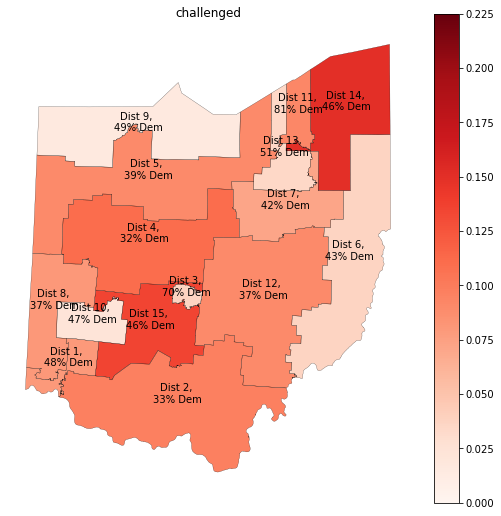

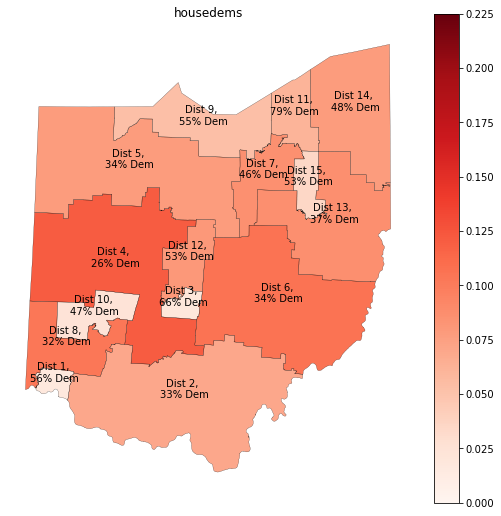

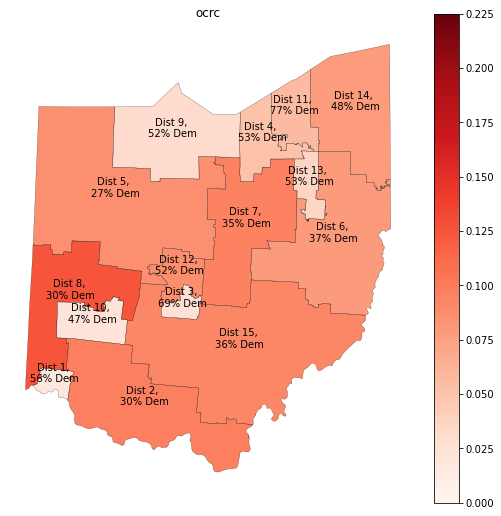

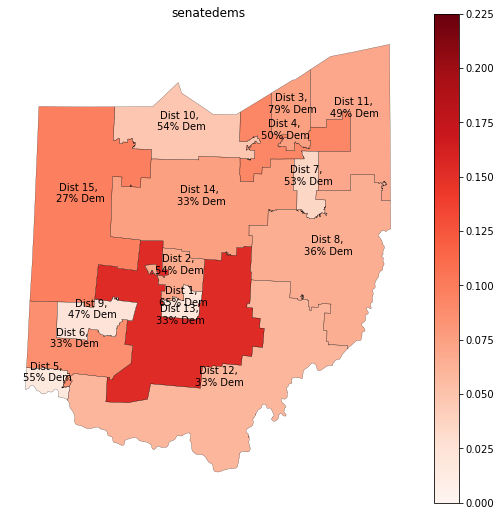

In [3]:
import pandas as pd

for a in authors:
    df = dislocation_points[a]
    print(f"For map by {a}:")
    print(
        f"Avg absolute dislocation over all voters is {df.abs_partisan_dislocation.mean():0.4f}"
    )

    dist_scores = df.groupby("DISTRICT", as_index=False)[
        ["abs_partisan_dislocation", "knn_shr_dem", "district_dem_share"]
    ].mean()

    dist = pd.merge(
        districts[a],
        dist_scores,
        on="DISTRICT",
        how="outer",
        validate="1:1",
        indicator=True,
    )
    dist._merge.value_counts()
    assert dist._merge.value_counts().loc["both"] == num_dists

    print(
        f"Most dislocated district for {a} has avg dislocation of {dist.abs_partisan_dislocation.max():0.3f}"
    )

    ax = dist.plot(
        "abs_partisan_dislocation",
        cmap="Reds",
        legend=True,
        figsize=(9, 9),
        vmin=0,
        vmax=0.225,
    )
    dist.apply(
        lambda x: ax.annotate(
            text=f'Dist {x["DISTRICT"]}, \n{x["district_dem_share"]:.0%} Dem',
            xy=x.geometry.centroid.coords[0],
            ha="center",
        ),
        axis=1,
    )
    dist.boundary.plot(edgecolor="black", ax=ax, linewidth=0.2)
    ax.set_title(a)
    ax.set_axis_off()
    ax.figure.savefig(f"../30_results/{a}_districts.png")


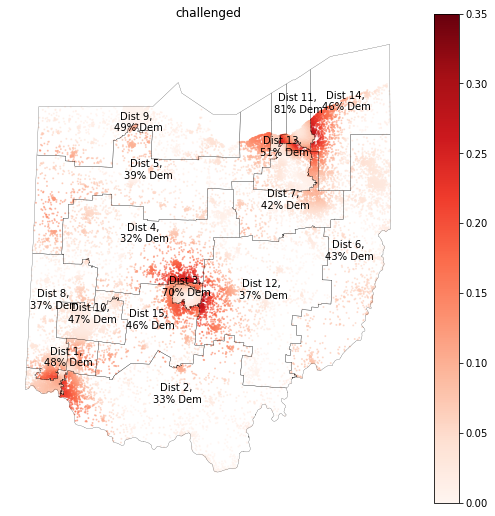

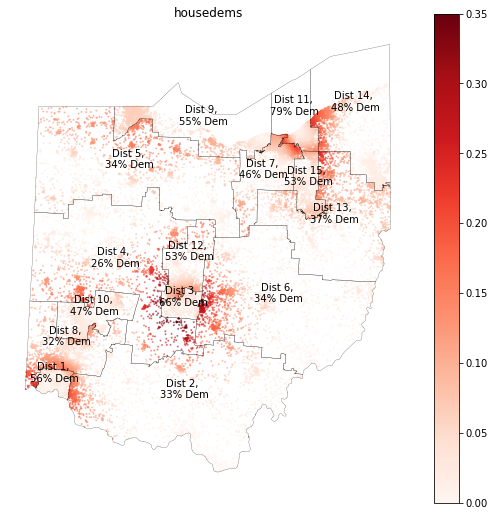

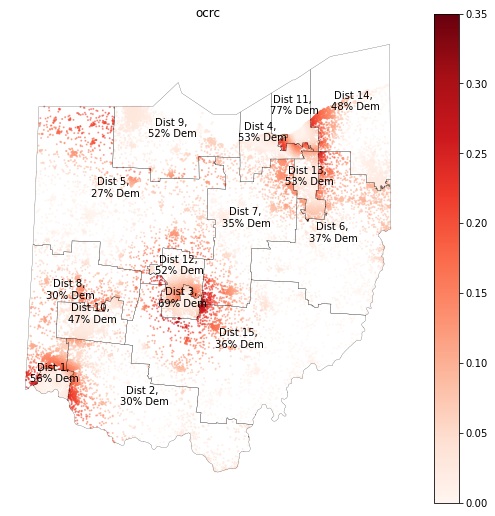

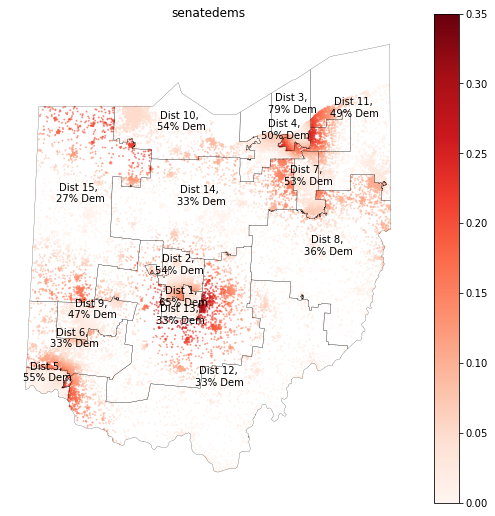

In [4]:
for a in authors:
    df = dislocation_points[a]
    ax = df.sample(frac=0.1).plot(
        "abs_partisan_dislocation",
        cmap="Reds",
        legend=True,
        figsize=(9, 9),
        vmin=0,
        vmax=0.35,
        markersize=1,
        alpha=0.5,
    )
    ax.set_title(a)

    dist_scores = df.groupby("DISTRICT", as_index=False)[
        ["abs_partisan_dislocation", "knn_shr_dem", "district_dem_share"]
    ].mean()

    dist = pd.merge(
        districts[a],
        dist_scores,
        on="DISTRICT",
        how="outer",
        validate="1:1",
        indicator=True,
    )
    dist._merge.value_counts()
    assert dist._merge.value_counts().loc["both"] == num_dists

    dist.boundary.plot(ax=ax, edgecolor="black", linewidth=0.2)

    dist.apply(
        lambda x: ax.annotate(
            text=f'Dist {x["DISTRICT"]}, \n{x["district_dem_share"]:.0%} Dem',
            xy=x.geometry.centroid.coords[0],
            ha="center",
        ),
        axis=1,
    )
    ax.set_axis_off()
    ax.figure.savefig(f"../30_results/{a}_points.png")


### Distribution of Dislocations Across Voters


In [5]:

import altair as alt
# alt.data_transformers.enable('data_server')
all_points = list()
for a in authors:
    df = dislocation_points[a]
    df["abs_partisan_dislocation_binned"] = pd.cut(df.abs_partisan_dislocation, np.arange(0, 0.4, 0.05))
    df["abs_partisan_dislocation_binned"].value_counts()
    df["author"] = a
    all_points.append(df.copy())
all_points = pd.concat(all_points)
hist = all_points.groupby(["abs_partisan_dislocation_binned", "author", "dem"], as_index=False)[["DISTRICT"]].count()
hist["n"] = hist["DISTRICT"]
hist["total"] = hist.groupby(["dem", "author"], as_index=False)[["DISTRICT"]].transform(np.sum)
hist["share"] = hist.n / hist.total
hist.head(6)


,abs_partisan_dislocation_binned,author,dem,DISTRICT,n,total,share
0,"(0.0, 0.05]",challenged,0,80069,80069,174270,0.459454
1,"(0.0, 0.05]",challenged,1,71045,71045,152205,0.466772
2,"(0.0, 0.05]",housedems,0,82929,82929,174141,0.476218
3,"(0.0, 0.05]",housedems,1,81279,81279,152159,0.534171
4,"(0.0, 0.05]",ocrc,0,87588,87588,174270,0.502599
5,"(0.0, 0.05]",ocrc,1,91475,91475,152205,0.600999


In [6]:
hist["Abs Partisan Dislocation"] = hist["abs_partisan_dislocation_binned"].apply(
    lambda x: x.left
)

domain = [1, 0]
range_ = ['blue', 'red']

c = (
    alt.Chart(pd.DataFrame(hist), title="Distribution of Abs Partisan Dislocation by Party")
    .mark_bar(opacity=0.5)
    .encode(
        x=alt.X("Abs Partisan Dislocation"),
        y=alt.Y("share", stack=None),
        column="author",
        color=alt.Color("dem:N", scale=alt.Scale(domain=domain, range=range_)),
    )
)
c


TypeError: Object of type Interval is not JSON serializable

alt.Chart(...)

In [ ]:
avges = all_points.groupby(["author", "dem"], as_index=False)[
    ["abs_partisan_dislocation"]
].mean()
avges = avges.rename(
    {"abs_partisan_dislocation": "Average Absolute Partisan Dislocation"},
    axis="columns",
)
avges


,author,dem,Average Absolute Partisan Dislocation
0,challenged,0,0.076137
1,challenged,1,0.076292
2,housedems,0,0.072268
3,housedems,1,0.063685
4,ocrc,0,0.071332
5,ocrc,1,0.059615
6,senatedems,0,0.068983
7,senatedems,1,0.063114


In [ ]:
c.save("../30_results/distribution_of_abs_dislocation_by_party.png")

## Signed Dislocation

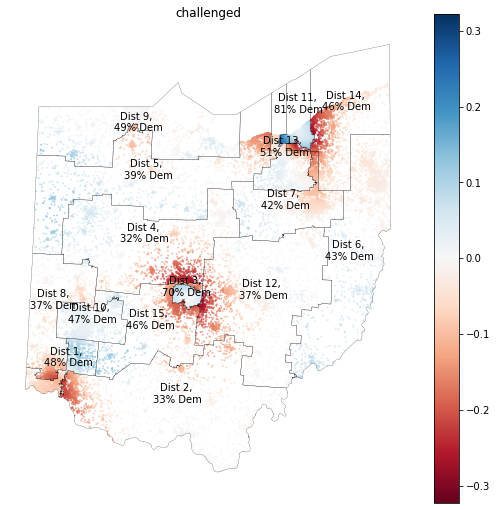

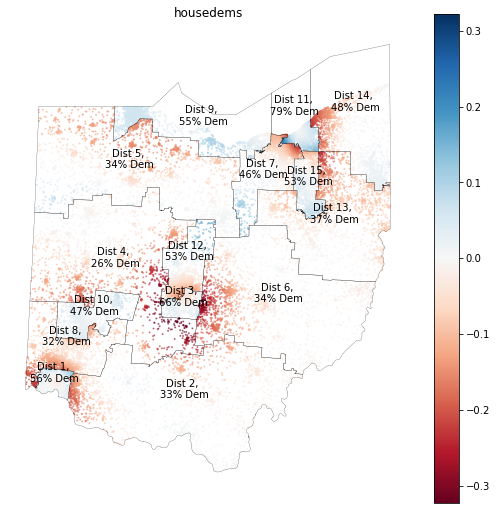

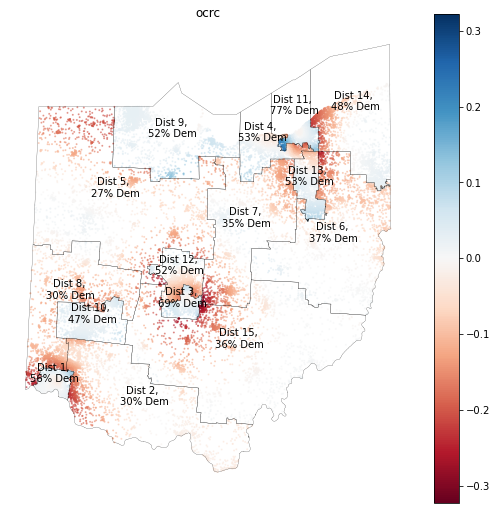

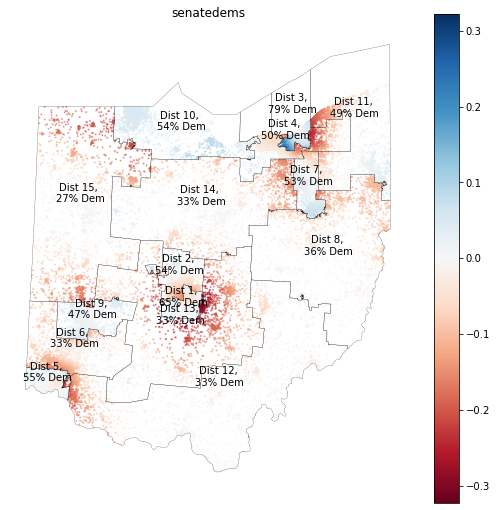

In [7]:

# Get extreme values
pd_max = 0
pd_min = 0
for a in authors:
    if candidate_max := df.partisan_dislocation.max():
        pd_max = candidate_max
    if candidate_min := df.partisan_dislocation.min():
        pd_min = candidate_min

limit = max([np.abs(pd_max), np.abs(pd_min)])

# Plot
for a in authors:
    df = dislocation_points[a]
    ax = df.sample(frac=0.1).plot(
        "partisan_dislocation",
        cmap="RdBu",
        legend=True,
        figsize=(9, 9),
        vmin=-limit,
        vmax=limit,
        markersize=1,
        alpha=0.5,
    )
    ax.set_title(a)


    dist_scores = df.groupby("DISTRICT", as_index=False)[
        ["abs_partisan_dislocation", "knn_shr_dem", "district_dem_share"]
    ].mean()

    dist = pd.merge(
        districts[a],
        dist_scores,
        on="DISTRICT",
        how="outer",
        validate="1:1",
        indicator=True,
    )
    dist._merge.value_counts()
    assert dist._merge.value_counts().loc["both"] == num_dists

    dist.boundary.plot(ax=ax, edgecolor="black", linewidth=0.2)

    dist.apply(
        lambda x: ax.annotate(
            text=f'Dist {x["DISTRICT"]}, \n{x["district_dem_share"]:.0%} Dem',
            xy=x.geometry.centroid.coords[0],
            ha="center",
        ),
        axis=1,
    )
    ax.set_axis_off()
    ax.figure.savefig(f"../30_results/{a}_signed_dislocation.png")
    


In [ ]:
for a in authors:
    m = (
        dislocation_points[a][["partisan_dislocation", "geometry"]]
        .sample(frac=0.1)
        .explore("partisan_dislocation", cmap="RdBu", vmin=-0.35, vmax=0.35)
    )
    m.save(f"../20_intermediate_files/interactive_folium_map_{a}.html")
